In [1]:
%%html 
<a href="javascript:code_showhide_toggle()">Show/Hide Code</a>

# Harmonize and Index Los Angeles Crime Incident Dataset

## Contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Load Input Data](#Load-Input-Data)
- [Exploratory Analysis](#Exploratory-Analysis)
- [Harmonize Variables](#Harmonize-Variables)
- [Add metadata for additional variables](#Add-metadata-for-additional-variables)
- [Generate Dictionary](#Generate-Dictionary)
- [Save Data and Dictionary](#Save-Data-and-Dictionary)
- [Create External Tables in Amazon Athena](#Create-External-Tables-in-Amazon-Athena)
- [Index Data and Dictionary](#Index-Data-and-Dictionary)
- [View Harmonized Data Sample](#View-Harmonized-Data-Sample)
- [View Data Dictionary](#View-Data-Dictionary)
- [Publish Notebook](#Publish-Notebook)

## Introduction 
This notebook will illustrate use of Jupyter with PySpark to 
- harmonize crime datasets from multiple jurisdictions
- add metadata to support a data driven search UI
- create a data dictionary with metadata for each variable
- save data and metadata as Spark SQL tables backed by (Athena compatible) Parquet files in S3
- index data and metadata to support search
- self-publish this notebook so it can be linked from the search UI to provide transparency and reproducability


## Setup

#### What does this do
This sets up our environment variables to use for data input, output, indexing, etc...

In [2]:
# CONFIGURATION VARIABLES
city="LosAngeles"
cityurl="https://data.lacounty.gov/api/views/ca5f-5zzs/rows.csv?accessType=DOWNLOAD"
citynotebook="LosAngeles-notebook"  # citynotebook is used to automatically publish the notebook at the end

# location for raw (unprocessed) dataset in S3
scratch_bucket=os.environ["S3_SCRATCH_BUCKET"]
datasets3 = "s3://{0}/crimedata/raw/{1}.csv".format(scratch_bucket, city)

# locaton for harmonized (processed) dataset in S3. Structure is:
#   outputroot
#       |--- data - incidents - multiple CSV files
#       |--- dictionary - incidents - CSV file containing data dictionary
#       |--- doc - copy of notebook (published for web access)
outputroot = "s3://{0}/crimedata/harmonized/{1}".format(scratch_bucket,city)
outputpath_data = "{}/data".format(outputroot)
outputpath_dictionary="{}/dictionary".format(outputroot)
outputpath_doc="{}/docs".format(outputroot)
notebook_urlbase = "https://s3.amazonaws.com/{0}/{1}".format(outputpath_doc.replace("s3://",""), citynotebook)

# elasticsearch cluster endpoint
# - use local proxy service (installed via an EMR bootstrap) which signs ES API calls using EMR EC2 role.
esendpoint="localhost"
esport=9200

# Summary of configuration
print("City: {}".format(city))
print("Notebook Name: {}".format(citynotebook))
print("Dataset URL: {}".format(cityurl))
print("S3 dataset input: {}".format(datasets3))
print("Harmonized output: {}".format(outputroot))
print("ElasticSearch Cluster: {}.{}".format(esendpoint, esport))
print("Setup & Initialization done")

City: LosAngeles
Notebook Name: LosAngeles-notebook
Dataset URL: https://data.lacounty.gov/api/views/ca5f-5zzs/rows.csv?accessType=DOWNLOAD
S3 dataset input: s3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/raw/LosAngeles.csv
Harmonized output: s3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/harmonized/LosAngeles
ElasticSearch Cluster: localhost.9200
Setup & Initialization done


In [3]:
# INITIALIZATION - instantiate objects used by notebook

%matplotlib inline
from pyspark import SparkContext
from pyspark.sql import HiveContext
from pyspark.sql.functions import *
from IPython.display import display, HTML
import datetime
import subprocess

# elasticsearch and harmonization objects defined in ./lib/esindex.py and ./lib/harmonizeCrimeIncidents.py
from lib.esindex import esindex
from lib.harmonizeCrimeIncidents import harmonizeCrimeIncidents

sc = SparkContext.getOrCreate()
hc = HiveContext(sc)
es = esindex(esendpoint)
hz = harmonizeCrimeIncidents(hc)
print("Initialization complete.")

Initialization complete.


## Load Input Data

#### What does this do
This takes a data source file, in our case a CSV file, and puts it into our S3 bucket for procssing. Once the source file is copied into the bucket, we will load the file into a Spark dataframe for analysis and processing.

In [4]:
# Download & install dataset from website

def copy_from_website_to_s3(city, cityurl, datasets3):
    tmpfile="/tmp/{0}.csv".format(city)
    print("Downloading {0} from: {1}".format(tmpfile, cityurl))
    subprocess.check_output("curl {0} -o {1}".format(cityurl, tmpfile).split())
    print("Copying {0} to: {1}".format(tmpfile, datasets3))
    subprocess.check_output("aws s3 cp {0} {1} --sse AES256".format(tmpfile, datasets3).split())
    os.remove(tmpfile)
    
# uncomment if you want to re-download the dataset
copy_from_website_to_s3(city, cityurl, datasets3)


Copying /tmp/LosAngeles.csv to: s3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/raw/LosAngeles.csv


In [5]:
# Read input datasets as DataFrames
# No need to infer schema - all variables typed as strings
print("Loading dataset from S3")
df = hc.read.load( datasets3,
                   format='com.databricks.spark.csv',
                   header='true',
                   inferSchema='false',
                   delimiter=',') 
df_in=df # keep copy of raw data for reference
print("Dataset {0}: Loaded {1} rows.".format(city, df.count()))

Loading dataset from S3
Dataset LosAngeles: Loaded 172860 rows.


## Exploratory Analysis
Edit as desired to interactively explore the data

#### What does this do
With the data source file loaded into a Spark Data Frame, you can get some details on the content of the data using methods from Spark, Pandas, and others. This is purely exploratory information to give users insights into the raw data set.

In [6]:
# examine column headers
str(df.columns)

"['CRIME_DATE', 'CRIME_YEAR', 'CRIME_CATEGORY_NUMBER', 'CRIME_CATEGORY_DESCRIPTION', 'STATISTICAL_CODE', 'STATISTICAL_CODE_DESCRIPTION', 'VICTIM_COUNT', 'STREET', 'CITY', 'STATE', 'ZIP', 'LATITUDE', 'LONGITUDE', 'GANG_RELATED', 'REPORTING_DISTRICT', 'STATION_IDENTIFIER', 'STATION_NAME', 'CRIME_IDENTIFIER', 'LOCATION']"

In [7]:
# look at first 2 rows
df.head(2)

[Row(CRIME_DATE=u'02/05/2016 11:02:34 AM', CRIME_YEAR=u'2016', CRIME_CATEGORY_NUMBER=u'23', CRIME_CATEGORY_DESCRIPTION=u'VEHICLE / BOATING LAWS', STATISTICAL_CODE=u'255', STATISTICAL_CODE_DESCRIPTION=u'VEHICLE AND BOATING LAWS: Misdemeanor', VICTIM_COUNT=u'1', STREET=None, CITY=None, STATE=None, ZIP=None, LATITUDE=None, LONGITUDE=None, GANG_RELATED=u'N', REPORTING_DISTRICT=u'6885', STATION_IDENTIFIER=u'CA0190031', STATION_NAME=u'TRANSIT SERV BUR', CRIME_IDENTIFIER=u'17631177', LOCATION=None),
 Row(CRIME_DATE=u'12/17/2016 02:12:41 PM', CRIME_YEAR=u'2016', CRIME_CATEGORY_NUMBER=u'20', CRIME_CATEGORY_DESCRIPTION=u'VAGRANCY', STATISTICAL_CODE=u'222', STATISTICAL_CODE_DESCRIPTION=u'VAGRANCY/QUALITY OF LIFE:Illegal Vending', VICTIM_COUNT=u'1', STREET=None, CITY=None, STATE=None, ZIP=None, LATITUDE=None, LONGITUDE=None, GANG_RELATED=u'N', REPORTING_DISTRICT=u'2170', STATION_IDENTIFIER=u'CA01900V3', STATION_NAME=u'CENTURY', CRIME_IDENTIFIER=u'17998329', LOCATION=None)]

In [8]:
# look at the distinct values for 'CRIME_CATEGORY_DESCRIPTION'
df.select('CRIME_CATEGORY_DESCRIPTION').distinct().show(truncate=False)

+----------------------------+
|CRIME_CATEGORY_DESCRIPTION  |
+----------------------------+
|VEHICLE / BOATING LAWS      |
|LIQUOR LAWS                 |
|CRIMINAL HOMICIDE           |
|FRAUD AND NSF CHECKS        |
|OFFENSES AGAINST FAMILY     |
|null                        |
|FELONIES MISCELLANEOUS      |
|WARRANTS                    |
|FEDERAL OFFENSES WITH MONEY |
|ARSON                       |
|AGGRAVATED ASSAULT          |
|GAMBLING                    |
|LARCENY THEFT               |
|DRUNK DRIVING VEHICLE / BOAT|
|SEX OFFENSES FELONIES       |
|SEX OFFENSES MISDEMEANORS   |
|DRUNK / ALCOHOL / DRUGS     |
|FORGERY                     |
|WEAPON LAWS                 |
|MISDEMEANORS MISCELLANEOUS  |
+----------------------------+
only showing top 20 rows



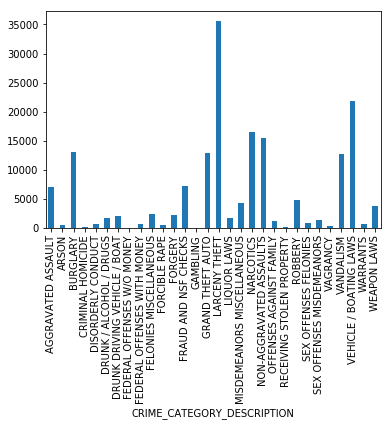

In [9]:
# Graph incident count by Description
descr = df.select('CRIME_CATEGORY_DESCRIPTION').toPandas()
descrGrp = descr.groupby('CRIME_CATEGORY_DESCRIPTION').size().rename('counts')
descrPlot = descrGrp.plot(kind='bar')

## Harmonize Variables

Standard harmonised variables for crime incident datasets are defined in ./lib/harmonizeCrimeIncidents.py
(You can open this module in JupyterNB, and modify the variable list and associated standard variable metadata as required) 

#### What does this do
Harmonization is the process of mapping the raw variables of each incoming dataset to use the standard 'harmonized' 
variables and associated units of measurement, as much as possible. Harmonized datasets support cross-dataset search as well as the ability to combine/union datasets to perform multi dataset analysis and research.

See examples below for how to generate new variables from existing variables, and how to manipulate variable values. The hz (harmonizeCrimeIncidents) class provides methods to help abstract the code for some common actions. 

#### Why are we doing this
A core challenge when combining loosely coupled in a combined search index is dealing with different names for the same attribute. For example "Sex" versus "Gender" or "48in" versus "4ft". We have a pre-defined set of standard variable names and types that we are using for our search page, the harmonization process ensures that attributes and values in the raw data files to match that predifined set to allow for a consistent search tool across multiple data sets.

In [10]:
# Use hz.mapVar(old,new, keepOrig=False) to create new variables from the original variables, by default dropping 
# the original variable. Use keepOrig=True argument to keep the original variable in the dataset.
# Metadata for the transformation will be captured and included in the data dictionary

df = hz.mapVar(df, "STREET", "location")
df = hz.mapVar(df, "STATION_NAME", "neighbourhood", keepOrig=True)

# Rename any variables that have illegal names 
# no illegal characters or spaces (required to support parquet output format)
# all lowercase variable names (required to provide compatibility with Amazon Athena)
df = hz.makeValidVariableNames(df)

New variable <location> created from <STREET>
Dropped variable <STREET>
New variable <neighbourhood> created from <STATION_NAME>
New variable <crime_date> created from <CRIME_DATE>
New variable <crime_year> created from <CRIME_YEAR>
New variable <crime_category_number> created from <CRIME_CATEGORY_NUMBER>
New variable <crime_category_description> created from <CRIME_CATEGORY_DESCRIPTION>
New variable <statistical_code> created from <STATISTICAL_CODE>
New variable <statistical_code_description> created from <STATISTICAL_CODE_DESCRIPTION>
New variable <victim_count> created from <VICTIM_COUNT>
New variable <city> created from <CITY>
New variable <state> created from <STATE>
New variable <zip> created from <ZIP>
New variable <latitude> created from <LATITUDE>
New variable <longitude> created from <LONGITUDE>
New variable <gang_related> created from <GANG_RELATED>
New variable <reporting_district> created from <REPORTING_DISTRICT>
New variable <station_identifier> created from <STATION_IDE

In [11]:
# Harmonize Description variable to standard values.
df = hz.mapVar(df, "CRIME_CATEGORY_DESCRIPTION", "Description", keepOrig=True)  # make a new copy of Description variable, original renamed
# map value to standard descriptions
descrMappings = {
    "AGGRAVATED ASSAULT" : "Assault",
    "ARSON" : "Arson",
    "BURGLARY" : "Burglary",
    "CRIMINAL HOMICIDE" : "Homicide",
    "DISORDERLY CONDUCT" : "Miscellaneous",
    "DRUNK / ALCOHOL / DRUGS" : "OUI",
    "DRUNK DRIVING VEHICLE / BOAT" : "OUI",
    "FEDERAL OFFENSES W/O MONEY" : "Miscellaneous",
    "FEDERAL OFFENSES WITH MONEY" : "Miscellaneous",
    "FELONIES MISCELLANEOUS" : "Miscellaneous",
    "FORCIBLE RAPE" : "Rape",
    "FORGERY" : "Miscellaneous",
    "FRAUD AND NSF CHECKS" : "Fraud",
    "GAMBLING" : "Miscellaneous",
    "GRAND THEFT AUTO" : "Vehicle Theft",
    "LARCENY THEFT" : "Theft",
    "LIQUOR LAWS" : "Miscellaneous",
    "MISDEMEANORS MISCELLANEOUS" : "Miscellaneous",
    "NARCOTICS" : "Narcotics",
    "NON-AGGRAVATED ASSAULTS" : "Assault",
    "OFFENSES AGAINST FAMILY" : "Miscellaneous",
    "RECEIVING STOLEN PROPERTY" : "Miscellaneous",
    "ROBBERY" : "Robbery",
    "SEX OFFENSES FELONIES" : "Sex Offenses",
    "SEX OFFENSES MISDEMEANORS" : "Sex Offenses",
    "VAGRANCY" : "Miscellaneous",
    "VANDALISM" : "Miscellaneous",
    "VEHICLE / BOATING LAWS" : "Miscellaneous",
    "WARRANTS" : "Miscellaneous",
    "WEAPON LAWS" : "Weapons"
}
df = hz.mapValues(df, "description", descrMappings)

New variable <Description> created from <CRIME_CATEGORY_DESCRIPTION>
Values for description converted per supplied mapping


In [12]:
# Add city variable. All rows are given the value of the current city name
df = df.withColumn('city', lit(city)) 

# Add TransformDescr metadata field
hz.addTransformDescr('city','"city" assigned by harmonization code')
print("Add 'city' variable")

Add 'city' variable


Cleanup and harmonise geographic co-ordinate variables. 
As we can see below, both latitude and longitude variables have rows with invalid values - empty strings and invalid coordinates.
For this example we will simply remove those rows from our dataset, in order to avoid constructing invalid geo-point coordinates that will cause failuers when attempting to index into elasticsearch later.

In [13]:
df.select('latitude').distinct().sort('latitude', ascending=True).show(10)

+--------------------+
|            latitude|
+--------------------+
|                null|
|-148729881.698397...|
|-148729881.720660...|
|-148729881.725253...|
|-148729881.741598...|
|-148729881.970412...|
|-148729882.011821...|
|-148729882.042453...|
|  33.333295355757807|
|  33.335784313433094|
+--------------------+
only showing top 10 rows



In [14]:
df.select('longitude').distinct().sort('longitude', ascending=True).show(10)

+--------------------+
|           longitude|
+--------------------+
|                null|
|-117.655767442441663|
|-117.655835654548161|
|-117.655874238324889|
|-117.657129324924499|
|-117.660092027012396|
|-117.660094787095011|
|-117.661437005844522|
|-117.662237245315054|
|-117.666570005900531|
+--------------------+
only showing top 10 rows



In [15]:
# filter out records with invalid latitude or longitude coordinates
c1 = df.count()
# eliminate empty & null values
df = df.where(length('latitude') > 0).where(length('longitude') > 0)
# eliminate invalid (negative) latitude values.. All northen hemisphere values expected to be postive
df = df.where(df.latitude > 0)
c2 = df.count()
print("Deleted {} rows with corrupted coordinates in latitude and longitude".format(c1-c2))

Deleted 11421 rows with corrupted coordinates in latitude and longitude


In [16]:
# Format GeoLocation field by combining latitude and longitude
df = df.withColumn('geolocation', concat(df.latitude, lit(','),df.longitude)) 
df = df.drop('latitude').drop('longitude')
hz.addTransformDescr('geolocation','geolocation variable created from latitude and longitude variables')
print("Generated Harmonized geolocation variable, and dropped original latitude and longitude variables")

Generated Harmonized geolocation variable, and dropped original latitude and longitude variables


In [17]:
# Generate standard datetime, date part, and time part fields from raw crime_date field
# for simplicity we will keep all times in localtime (ignoring timezones)

# Split crime_date into year, month, day (all defined as harmonized variables in the hz class)
# crime_date is formatted as month/day/year hour:minute AM|PM
regex=r'(\d+)/(\d+)/(\d+) (\d+):(\d+):(\d+) (\w\w)'
df = df.withColumn('month', regexp_extract('crime_date', regex, 1))
hz.addTransformDescr('month','month, extracted from crime_date')

df = df.withColumn('day', regexp_extract('crime_date', regex, 2))
hz.addTransformDescr('day','day, extracted from crime_date')

df = df.withColumn('year', regexp_extract('crime_date', regex, 3))
hz.addTransformDescr('year','year, extracted from crime_date')

df = df.withColumn('hour', regexp_extract('crime_date', regex, 4))   

df = df.withColumn('hour', regexp_replace('hour', '24', '00')) 
hz.addTransformDescr('hour','hour, extracted from crime_date')

df = df.withColumn('minute', regexp_extract('crime_date', regex, 5)) 
hz.addTransformDescr('minute','minute, extracted from crime_date')

df = df.withColumn('AMPM', regexp_extract('crime_date', regex, 7)) 

# Convert hour to 24hr format
df = df.withColumnRenamed('hour', 'hour_tmp')
selectExpr = "IF( ampm = 'PM', cast((cast(hour_tmp as int) + 12) as string), hour_tmp ) AS hour"
df=df.selectExpr(selectExpr,"*").drop('hour_tmp').drop('ampm')  
df = df.withColumn('hour', regexp_replace('hour', '24', '00'))  # replace 24:00 with 00:00

# Create new datetime field in format YYYY-MM-DD hhmm (defined as a harmonized variable in the hz class)
df = df.withColumn('datetime',concat(concat_ws('-',df.year,df.month,df.day),lit(' '),concat_ws(':',df.hour,df.minute,lit('00'))).cast("timestamp"))
hz.addTransformDescr('datetime','Full timestamp with date and time, eg 2007-04-05 14:30')  

# Drop the original crime_date and CRIME_YEAR variables - no longer needed
df = df.drop('crime_date').drop('crime_year')

# Cast all the date time part fields from string to int (allows use of numeric range filters in the search UI)
for col in ['year','month','day','hour','minute']:
    df = df.withColumn(col, df[col].cast("int"))

# Add dayofweek variable, eg Monday, Tuesday, etc. (defined as a harmonized variable in the hz class)
df = df.withColumn('dayofweek',date_format('datetime', 'EEEE'))
hz.addTransformDescr('dayofweek','day of Week, calculated from datetime')  

print("Harmonized date & time variables")

Harmonized date & time variables


In [18]:
df.select('datetime').show(2,truncate=False)

+---------------------+
|datetime             |
+---------------------+
|2016-06-11 23:06:00.0|
|2016-07-21 09:07:00.0|
+---------------------+
only showing top 2 rows



In [19]:
# Add dataset descriptive variables (defined in hz class). 

# location of raw data
df = df.withColumn('rawdatapath', lit(datasets3))
hz.addTransformDescr('rawdatapath','Assigned by harmonization code')

# location of harmonized data
df = df.withColumn('harmonizeddatapath', lit(outputroot))
hz.addTransformDescr('harmonizeddatapath','Assigned by harmonization code')

# URL for this notoebook (notebook will be saved/published using cells at the end of the notebook)
df = df.withColumn('notebookhtml', lit(notebook_urlbase + ".html"))
hz.addTransformDescr('notebookhtml','Assigned by harmonization code')

print("Added dataset descriptive variables")

Added dataset descriptive variables


# Add metadata for additional variables
Create some additional variables for this specific data set.

Here we can assign a default 'vargroup' for all variables that are not part of the defined list of harmonized variables in the hz class, using the hz.addVarGroup() method.
(The 'vargroup' is used by the search UI to group variables under 'accordian' panels in the search page side bar).

We can also assign custom metadata to selected unharmonized variables as desired. NOTE:
 - default metadata for harmonized variables is defined in the hz class already, so we can ignore those
 - unharmonized variables will be assigned default metadata automatically when we build the data dictionary below using hz.buildDataDict(). However, you might want to explicitly assign metadata to selected variables to control the search UI widget type, and/or to add descriptions to the dictionary.
 
#### What does this do
This process adds customized search parameters to this specific data set in the UI that aren't part of our standard set.

#### Why are we doing this
Not all individual variables within a single data set are always valuable on their own. Some need some additional logic or combination to make search and discovery a better experience. This process allows the harmonization routine to apply that logic and expose it within the UI

In [20]:
# vargroups are used to define the Search Filter UI 'accordians' and their order
# set default variable group - used if variable is not exicitly assigned to a group
defaultVarGroup = "{0} (Unharmonized)".format(city)
hz.addVarGroup(defaultVarGroup,order=90,default=True)

# Metadata for the harmonized variables is already defined in 'hz' class.
# Use hz.addVarMetadata() to add metadata for additional (non harmonized) variables to control
# how they are presented in the data dictionary and search UI.

# Here, "GANG_RELATED" is not defined as one of the standard harmonized variables, but we can configure how it will be 
## handled in the filter UI by setting metadata here.
# First, convert the Y/N values to 1|0 (true|false) and cast to int, to support a boolean selector
df = hz.mapValues(df, "gang_related", {"Y":1,"N":0})
df = df.withColumn('gang_related', df['gang_related'].cast("int"))
# Then set 'type' to boolean, which will generate a True/False selector in the UI. 
hz.addVarMetadata("gang_related", 
                 vargroup=defaultVarGroup, 
                 type="boolean", 
                 descr="Incident is gang related?", 
                 uifilter=True)
print("Converted variable <gang_related> to boolean and added metadata")

Values for gang_related converted per supplied mapping
Converted variable <gang_related> to boolean and added metadata


In [21]:
df.head(2)

[Row(gang_related=0, hour=23, description=u'Miscellaneous', crime_category_number=u'23', crime_category_description=u'VEHICLE / BOATING LAWS', statistical_code=u'250', statistical_code_description=u'VEHICLE AND BOATING LAWS: Hit And Run, Misdemeanor', victim_count=u'1', city=u'LosAngeles', state=u'CA', zip=None, reporting_district=u'2290', station_identifier=u'CA0190022', station_name=u'MALIBU/LOST HILLS', crime_identifier=u'17788596', location=u'PENLAND RD AND LONG VALLEY RD', neighbourhood=u'MALIBU/LOST HILLS', geolocation=u'34.162644982309975,-118.651741997145288', month=6, day=11, year=2016, minute=6, datetime=datetime.datetime(2016, 6, 11, 23, 6), dayofweek=u'Saturday', rawdatapath=u's3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/raw/LosAngeles.csv', harmonizeddatapath=u's3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/harmonized/LosAngeles', notebookhtml=u'https://s3.amazonaws.com/datasearch-blog-jupyterspark-180dxejof

## Generate Dictionary
Generate a dictionary table containing field distribution stats and metadata data from the mappings 

#### What does this do
All variables that a) don't match standard harmonized variables, and b) don't have added metadata will be assigned to the default vargroup, and the variable type will be derived from the data distribution characteristics, calculated by hz.buildDataDict().

#### Why are we doing this
The data dictionary is used to generate dynamic search widgets and tools based on the data sets themselves. By basing our search widgets on the data itself, rather than hard-coded, it allows the search UI to update based on available data.

In [22]:
df_dict = hz.buildDataDict(df)
print("Data Dictionary created.")

Data Dictionary created.


## Save Data and Dictionary
Use the hiveContext object 'hc' to create a new schema for this city, and save the data dafarame and dictionary dataframe as tables in this schema with the hz.saveAsParquetTable() method. 

#### What does this do
Data and the associated dictionary information is saved to the S3 output path as parquet files.

#### Why are we doing this
This allows the tables we've created or modified through harmonization to be easily restored, combined, and analysed using SQL.

In [23]:
# Drop and create schema
schema="incidents"
hc.sql("DROP SCHEMA IF EXISTS {0} CASCADE".format(schema))
hc.sql("CREATE SCHEMA {0} COMMENT 'Crime incident data for {0}'".format(schema))

# Create Incident Data as SparkSQL table with S3 backed storage
data_table=city.lower()
data_table_ddl=hz.saveAsParquetTable(df,schema,data_table,outputpath_data)

# Create Dictionary as SparkSQL table with S3 backed storage
dict_table = data_table+"_dict"
dict_table_ddl=hz.saveAsParquetTable(df_dict.coalesce(1),schema,dict_table,outputpath_dictionary)

print "Done creating tables"

Creating Spark SQL table: incidents.losangeles
Creating Spark SQL table: incidents.losangeles_dict
Done creating tables


## Create External Tables in Amazon Athena

#### What does this do

The S3 parquet files containing the harmonizd data are registered as Amazon Athena external tables.

#### Why are we doing this

You can use Amazon Athena to perform detailed ad-hoc analysis of this and other harmonised datasets using the familiar power of SQL. Using Athena also allows you to easily integrate the dataset with Amazon Quicksight where you can create visual analyses and dashboards.

In [24]:
ddlList=[
    "CREATE DATABASE IF NOT EXISTS `{0}`;".format(schema),
    "DROP TABLE IF EXISTS `{0}`.`{1}`;".format(schema,data_table),
    "DROP TABLE IF EXISTS `{0}`.`{1}`;".format(schema,dict_table),
    data_table_ddl,
    dict_table_ddl
]
athena_s3_staging_dir = "s3://{0}/athena_staging_dir".format(scratch_bucket)
hz.executeAthenaDDL(athena_s3_staging_dir, ddlList)

Exectuting Athena DDL: CREATE DATABASE IF NOT EXISTS `incidents`;
Exectuting Athena DDL: DROP TABLE IF EXISTS `incidents`.`losangeles`;
Exectuting Athena DDL: DROP TABLE IF EXISTS `incidents`.`losangeles_dict`;
Exectuting Athena DDL: CREATE EXTERNAL TABLE `incidents`.`losangeles` (`gang_related` INT, `hour` INT, `description` STRING, `crime_category_number` STRING, `crime_category_description` STRING, `statistical_code` STRING, `statistical_code_description` STRING, `victim_count` STRING, `city` STRING, `state` STRING, `zip` STRING, `reporting_district` STRING, `station_identifier` STRING, `station_name` STRING, `crime_identifier` STRING, `location` STRING, `neighbourhood` STRING, `geolocation` STRING, `month` INT, `day` INT, `year` INT, `minute` INT, `datetime` TIMESTAMP, `dayofweek` STRING, `rawdatapath` STRING, `harmonizeddatapath` STRING, `notebookhtml` STRING)
STORED AS parquet
LOCATION 's3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/harmonized/LosA

## Index Data and Dictionary

#### What does this do
Creates or replaces the elastic search index to store our harmonized data and assoicated dictionary file

#### Why are we doing this
We save both incident data and dictionary information to elastic search, to power the search page.
The dictionary fields are used to dynamically build the search filter panels in the search page side bar - these fields identify each variable, it's vargroup (accordian panel), type (ui selector to use), & description (hover tooltip).
The incident record fields are used for the dataset record search.

Call  es.createOrReplaceIndex(es_index) to reset and set up default field mappings for the index (see ./lib/elasticsearch.py for more info on default mappings). 
You can also optionally specify field mappings for individual fields using es.addTypeMapping() as illustrated below, to support the search features you need - for example use a mapping to set date type for timestamps, or to speficy geo_point field if you want to use maps in your Kibana dashboard.

In [25]:
# set up data index
# index name city name for uniqueness, and *harmonized* to allow ES queries across all datasets
es_dataindex = "{0}_harmonized".format(city.lower())
es_datatype = 'incidents'
es.createOrReplaceIndex(es_dataindex)

# create mappings for geolocation and datetime field.. all other fields inherit default mapping
mapping="""
{
    "properties": {
        "geolocation": {
          "type": "geo_point"
        },
        "datetime": {
          "type": "date",
          "format" : "yyyy-MM-dd HH:mm:ss"}
        }
    }
}
"""
es.addTypeMapping(es_dataindex, es_datatype, mapping)

Deleted existing elasticsearch documents (losangeles_harmonized)
Create index <losangeles_harmonized> response: {"acknowledged":true}
Add type mapping for <losangeles_harmonized.incidents> response: {"acknowledged":true}


In [26]:
# set up dictionary index
# index name city name for uniqueness, and *dictionary* to allow ES queries across all datasets
es_dictindex = "{0}_dictionary".format(city.lower())
es_dicttype = 'dictionary'
es.createOrReplaceIndex(es_dictindex)

Deleted existing elasticsearch documents (losangeles_dictionary)
Create index <losangeles_dictionary> response: {"acknowledged":true}


All data and dictionary fields can be indexed, by calling ex.saveToEs() and passing the df and df_dict object directly, as shown below.
If instead you want to index a subset of the variables, make copy of the data dataframe, drop columns you don't want to index, generate a new dictionary dataframe using the new data dataframe as the argument to hz.buildDataDict(df_for_indexing), and pass the new data and dictionary dataframes to es.saveToEs() as shown below.

In [27]:
# index all variables in data dataframe
print("Saving data to elasticsearch - please be patient")
df = df.withColumn("datetime",df["datetime"].cast("string")) # elasticsearch needs datetimes in a string type
es.saveToEs(df,index=es_dataindex,doctype=es_datatype)

Saving data to elasticsearch - please be patient
Dataset 1 saved to elasticsearch <losangeles_harmonized/incidents>


In [28]:
# index all variables in dictionary dataframe
print("Saving dictionary to elasticsearch - please be patient")
es.saveToEs(df_dict,index=es_dictindex,doctype=es_dicttype)

Saving dictionary to elasticsearch - please be patient
Dataset 1 saved to elasticsearch <losangeles_dictionary/dictionary>


## View Harmonized Data Sample

#### What does this do
Test that the data table was sucessfully created by using SQL to load a few rows.

#### Why are we doing this
What we see below is what will be exposed in the search UI, so we want to see what our harmonized data looks like. Did we get all the right headers? Does it match the target data type? Is any applied logic correct? etc... 

In [29]:
sql="SELECT * FROM %s.%s LIMIT 3" % (schema, data_table)
# run query, convert results to a local pandas dataframe, and display as an HTML table.
HTML(hc.sql(sql).toPandas().to_html())

,gang_related,hour,description,crime_category_number,crime_category_description,statistical_code,statistical_code_description,victim_count,city,state,zip,reporting_district,station_identifier,station_name,crime_identifier,location,neighbourhood,geolocation,month,day,year,minute,datetime,dayofweek,rawdatapath,harmonizeddatapath,notebookhtml
0,0,1,Miscellaneous,24,VANDALISM,264,VANDALISM: Graffiti/Tagging,1,LosAngeles,CA,90713,1326,CA0190013,LAKEWOOD,18011973,6700 DEL AMO BLVD,LAKEWOOD,"33.846502560003428,-118.100904422619492",1,2,2017,1,2017-01-02 01:01:00,Monday,s3://datasearch-blog-jupyterspark-180dxejofo-e...,s3://datasearch-blog-jupyterspark-180dxejofo-e...,https://s3.amazonaws.com/datasearch-blog-jupyt...
1,0,15,Miscellaneous,24,VANDALISM,263,VANDALISM FELONY,1,LosAngeles,CA,None,2603,CA01900W9,PALMDALE,17675235,2730 BUTTERCUP DR,PALMDALE,"34.548028576745566,-118.078934775399617",3,19,2016,3,2016-03-19 15:03:00,Saturday,s3://datasearch-blog-jupyterspark-180dxejofo-e...,s3://datasearch-blog-jupyterspark-180dxejofo-e...,https://s3.amazonaws.com/datasearch-blog-jupyt...
2,0,4,Narcotics,16,NARCOTICS,185,Misdemeanor Possessn of a Controlled Substance...,1,LosAngeles,CA,90046,0973,CA0190009,WEST HOLLYWOOD,17862232,1200 N VISTA ST,WEST HOLLYWOOD,"34.092571514199761,-118.351744412126732",8,6,2016,8,2016-08-06 04:08:00,Saturday,s3://datasearch-blog-jupyterspark-180dxejofo-e...,s3://datasearch-blog-jupyterspark-180dxejofo-e...,https://s3.amazonaws.com/datasearch-blog-jupyt...


## View Data Dictionary

#### What does this do
Test the summary of the data to verify our dictionary was successfully created

#### Why are we doing this
The data dictionary drives how the data is organized and presented in the UI. We want to ensure we have our expected row counts, data types, mins and means, and that data is organized correctly for display in the UI. What we see here will translate into the search widgets and any available ranges that control those widgets.

In [30]:
sql="SELECT * FROM %s.%s ORDER BY dict_field ASC" % (schema, dict_table)
# run query, convert results to a local pandas dataframe, and display as an HTML table.
HTML(hc.sql(sql).toPandas().to_html())

,dict_field,dict_count,dict_countdistinct,dict_countmissing,dict_mean,dict_stddev,dict_min,dict_max,dict_vargroup,dict_vardescr,dict_uifilter,dict_varmapping,dict_vartype
0,city,161439,1,0,NaN,NaN,LosAngeles,LosAngeles,04.Location,Incident city,True,"Source CITY. ""city"" assigned by harmonization ...",text
1,crime_category_description,161439,30,0,NaN,NaN,AGGRAVATED ASSAULT,WEAPON LAWS,90.LosAngeles (Unharmonized),unknown,True,Source CRIME_CATEGORY_DESCRIPTION. Variable va...,text
2,crime_category_number,161439,30,0,NaN,NaN,1,9,90.LosAngeles (Unharmonized),unknown,True,Source CRIME_CATEGORY_NUMBER. Variable value u...,text
3,crime_identifier,161439,161439,0,NaN,NaN,16474037,18032284,90.LosAngeles (Unharmonized),unknown,True,Source CRIME_IDENTIFIER. Variable value unchan...,text
4,datetime,161439,8776,0,NaN,NaN,2016-01-20 00:01:00,2017-01-20 01:01:00,00.Date and Time,Incident date and time,True,"Full timestamp with date and time, eg 2007-04-...",datetime
5,day,161439,31,0,15.762486,8.854145,1,31,00.Date and Time,Incident date,True,"day, extracted from crime_date","enum,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17..."
6,dayofweek,161439,7,0,NaN,NaN,Friday,Wednesday,00.Date and Time,Incident day of week,True,"day of Week, calculated from datetime","enum,Sunday,Monday,Tuesday,Wednesday,Thursday,..."
7,description,161439,14,0,NaN,NaN,Arson,Weapons,01.Incident,Incident description,True,"Map values {""WEAPON LAWS"": ""Weapons"", ""VAGRANC...",text
8,gang_related,161439,2,0,0.017468,0.131007,0,1,90.LosAngeles (Unharmonized),Incident is gang related?,True,"Source GANG_RELATED. Map values {""Y"": 1, ""N"": 0}",boolean
9,geolocation,161439,90046,0,NaN,NaN,"33.333295355757807,-118.310438737128455","34.820662388325244,-118.15607922235384",04.Location,Incident geoLocation coordinates,False,geolocation variable created from latitude and...,text


## Publish Notebook
Save the notebook using javascript to trigger the save_checkpoint method.

#### What does this do
Convert notebook .ipny to html, and use hz.publishNotebookToS3 to copy the .ipny and .html files to the target S3 folder with web access enabled.

#### Why are we doing this
This provides a record within the UI of all the harmonization logic used to transform the raw data into what is exposed through the search and discovery tool. This record allows for easier verification, enhancements, or modifications of harmonization routines.

In [31]:
%%html
<!- SHOW / HIDE CODE TOGGLE ->
<script>
    var code_hide=true; //true -> hide code at first
    function code_showhide_toggle() {
        if (code_hide){
            $('div.input').hide();
            $('div.prompt').hide();
        } else {
            $('div.input').show();
            $('div.prompt').show();
        }
        code_hide = !code_hide
    }
    $( document ).ready(code_showhide_toggle);
</script>

In [32]:
!date

Fri Jan 20 20:40:31 UTC 2017


In [33]:
%%javascript
// save current notebook
IPython.notebook.save_checkpoint()

<IPython.core.display.Javascript object>

In [34]:
# convert ipynb to html
!jupyter nbconvert --to html $citynotebook

[NbConvertApp] Converting notebook LosAngeles-notebook.ipynb to html
[NbConvertApp] Writing 413956 bytes to LosAngeles-notebook.html


In [37]:
# copy saved notebook (ipynb and html formats) to target S3 bucket
hz.publishNotebookToS3(outputpath_doc, notebook_urlbase, citynotebook) 
# move html copy of notebook into subfolder
f = citynotebook + ".html"
print("Move {} to subfolder ./html".format(f))
!mkdir -p ./html
os.rename(f,"./html/{}".format(f))

Copy LosAngeles-notebook.ipynb to s3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/harmonized/LosAngeles/docs/LosAngeles-notebook.ipynb
URL: https://s3.amazonaws.com/datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/harmonized/LosAngeles/docs/LosAngeles-notebook.ipynb
Copy LosAngeles-notebook.html to s3://datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/harmonized/LosAngeles/docs/LosAngeles-notebook.html
URL: https://s3.amazonaws.com/datasearch-blog-jupyterspark-180dxejofo-emrbucket-1fvo1qv4b0l67/crimedata/harmonized/LosAngeles/docs/LosAngeles-notebook.html
Move LosAngeles-notebook.html to subfolder ./html


In [36]:
print("Notebook execution complete.")

Notebook execution complete.
